<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
     <img style="float: right; padding-right: 10px" width="100" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
     </div>

**Clemson University**<br>
**Instructor(s):** Aaron Masino <br>

## Lab 5: Clustering

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

In [ ]:
SEED = 654321

# Learning Goals

By the end of this lab, you should be able to:
- Apply the scikit-learn standard scaler to continuous data
- Apply the scikit-learn KMeans and DBSCAN clustering method
- Apply the scipy agglomerative (hierarchy) clustering method 
- Apply and interpret cluster quality metrics including inertia (the elbow method) and silhouette score
- Compare results of different results using cluster quality metrics

# Part 1: Multshapes Data

In this lab, we use the scikit-learn libaray to apply different clustering methods to the _Multishapes_ dataset. First, let's explore this dataset to gain insight into the challenges that we might face with attempting to develop clusters.

In [ ]:
df_multishapes = pd.read_csv('../data/multishapes.csv')
df_multishapes.describe()

It is typically necessary to scale the data so that all variables are approximately of the same order. Although the values in this dataset are not on significantly different scales, we will demonstrate use of the scikit-learn [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to illustrate its use. There are many scaling methods, each with different characteristics. To learn more see, for example, [effects of ouliers on scalers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-minmax-scaler-section).

In [ ]:
# instantiate a StandardScaler object
scaler = StandardScaler()

# fit and transform the data - note if we were had a test set we would use fit on the training set and transform the train and test sets with the same scaler 
# (i.e., scaler.fit_transform(train) and scaler.transform(test), do not fit on the test set)
# this is a numpy array
ms_scaled = scaler.fit_transform(df_multishapes[['x','y']])

# convert the numpy array to a pandas dataframe
df_ms_scaled = pd.DataFrame(ms_scaled, index = df_multishapes['shape'], columns = ['x','y'])    
df_ms_scaled.describe()

Now let's plot the data to get a visual sense for the presence of clusters.

In [ ]:
msplot = df_ms_scaled.plot.scatter(x='x', y='y', c='Black', title='Multishapes Scaled', s=2)
msplot.set_xlabel("X")
msplot.set_ylabel("Y")

# Part 2: KMeans clustering with scikit-learn
Let's apply the scikit-learn [KMeans Clustering Method](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to the data. Recall, KMeans attempts to identify optimal cluster centroids based on the variable values. This works well for data that clusters in distinct "blobs" in which any two points in a given cluster can be connected with a straight line and not intersect another cluster. In the image above, one may contend that the two concentric rings are individual clusters. In that case, they do not satisfy this straight line test. We'll see that KMeans will not identify these as the clusters. Let's try it out.

Let's start with four clusters, i.e., `K=4`.

In [ ]:
K = 3
cluster_model = KMeans(n_clusters=K, random_state=SEED)
cluster_model.fit(df_ms_scaled)

Let's examine the results contained in the `cluster_model` object that has been fit to our multishapes data. Specifically, we'll look at:
-  `cluster_centers_` : the coordinates of the cluster centroids. These coordinates are _p-dimensional_ where _p_ is the number of variables in our dataset. In this example $p=2$
- `labels_` : the cluster label assigned to each point in our data. This array is _n-dimensional_ where _n_ is the number of samples in our dataset. In this example $n=1100$

In [ ]:
print("The cluster centers are: \n", cluster_model.cluster_centers_)
print("The first few labels are: \n", cluster_model.labels_[:10])
print("The shae of the labels is: \n", cluster_model.labels_.shape)

Let's plot the multishape data again. However, this time, let's use _matplotlib's_ `c` input argument to specify that the color the markers in teh scatter plot should be selected based on the cluster to which the sample belongs. We'll also plot the cluster centroids - remember these represent the "center" of the cluster.

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(df_ms_scaled['x'], df_ms_scaled['y'], c=cluster_model.labels_, s=10)
plt.scatter(cluster_model.cluster_centers_[:,0], cluster_model.cluster_centers_[:,1], c='red', s=75, marker='s')

## KMeans Cluster Quality
Now let's examine the quality of the clusters we obtained with KMeans. We'll consider two quality metrics: _Inertia_ (also known as the Elbow method) and the _Silhouette_ score.

### KMeans Cluster Inertia
Recall, inertia measures the total squared distance from points to their cluster's centroid. For high quality clusters (i.e., those for which the cluster members are very similar to each other) we expect this distance to be relatively small. However, we can always decrease this value by adding more clusters. If every point has its own cluster, then our distance would be zero (0), but this defeats the point of clustering. One way to determine a _reasonable_ number of clusters is to try increasing **k** until there is an inflection point in the rate of decrease (i.e., velocity) of the total squared distance. Let's examine this for KMeans applied to the multishapes data.

In [ ]:
# list to store the inertia values
tsd = []
for K in range(1,11):
    # fit a KMeans model with K clusters
    cluster_model = KMeans(n_clusters=K, random_state=SEED)
    cluster_model.fit(df_ms_scaled)
    # store the inertia value
    tsd.append(cluster_model.inertia_)

# plot the inertia values
plt.figure(figsize=(8,6))
plt.plot(range(1,11), tsd, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

Visual inspection of the plot suggests the inflection point for the inertia (i.e., the elbow) is at `K=4`. So perhaps this is the optimal number of clusters. You can try this out by going back to the code cell where we set `K=3` in the KMeans clustering model. In that cell, set `K=4` and then plot the result. Does this seem like a better set of clusters?

### KMeans Silhouett Score
As an alternative to the inertia scores, we now consider the _silhouette_ score. Let's say we have a data point $i$, and the cluster it belongs to is referred to as $C(i)$. We would like to define the quality of a cluster $C(i)$ based on how close its data points are to each other (within-cluster) compared to nearby clusters $C(j)$. The `Silhouette Scores` do this. The silhouette score range is [-1,1]; 1 indicates a good cluster fit for this dataum, 0 indicates a point on the decision boundary (equal average closeness to points intra-cluster and out-of-cluster), and negative values mean that datum might be better in a different cluster.

Specifically, let $a(i)$ denote the average distance data point $i$ is to the other points in the same cluster:

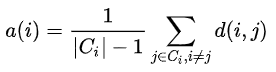

Similarly, we can compute the average distance that data point $i$ is to all **other** clusters. The cluster that yields the minimum distance is denoted by $b(i)$:  

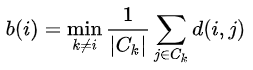

Ideally, our data point $i$ is much closer, on average, to points within its own cluster (i.e., $a(i)$ than it is to its closest neighboring cluster $b(i)$). The silhouette score quantifies this as $s(i)$:

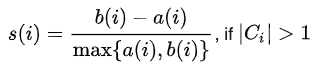

**NOTE:** If data point $i$ belongs to its own cluster (no other points), then the silhouette score is set to 0 (otherwise, $a(i)$ would be undefined).

Let use the sklearn [silhouete_score function](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.silhouette_score.html) to assess the cluster quality for different values of `K` when using KMeans clustering. __NOTE:__ The silhouette score plotted below is the **overall average** across all points in our dataset for indiviudal values of `K`.

In [ ]:
# list to store the silhouette values
scores = [0] # we set the score for 0 clusters to 0

for K in range(2,11):
    # fit a KMeans model with K clusters
    cluster_model = KMeans(n_clusters=K, random_state=SEED)
    cluster_model.fit(df_ms_scaled)
    # calculate the silhouette score
    score = silhouette_score(df_ms_scaled, cluster_model.labels_)
    scores.append(score)

# plot the silhouette values
plt.figure(figsize=(8,6))
plt.plot(range(1,11), scores, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette Score')
plt.title('The Silhouette Method showing the optimal $k$')
plt.show()

### Visualizing all silhouette  scores for a particular clustering

Below, we borrow from an `sklearn` example, see [here](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). In this plot, we will visualize the silhouette score for __ALL__ datapoints in the multishapes dataset. The function below accepts as input:
- `X` : the data to be clustered
- `clusterer` : an instance of a clustering method object (we'll use KMeans, but any sklearn clustering class instance will work)

In [ ]:
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, clusterer, pointlabels=None):
    cluster_labels = clusterer.labels_
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

Let's use this function to plot the Silhouette scores for KMeans with `K=4`.

In [ ]:
# run k-means with 4 clusters
cluster_model = KMeans(n_clusters=4, random_state=SEED).fit(df_ms_scaled)

# plot a fancy silhouette plot
silplot(df_ms_scaled.values, cluster_model)

# Part 3: Agglomerative clustering with scipy and Ward linkage
Let's apply the scipy [Hierarchical Clustering Method](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) to the multishapes data. Recall, agglomerative clustering starts by placing all samples into their own cluster and then progressively merging clusters until there is just one (1). The cluster merging step requires a __linkage function__ to compare similarity of cluster pairs.In this example, we'll use _Ward's method_. Recall, Ward's method is based on correlation of distance within variables of a cluster's samples. So we also need to define a distance function. We'll use the scipy [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) function which calculates pairwise distance between values in the input using a specified method - here we'll use `euclidean`. Finally, Scipy also provides a convenient `dendrogram` method to plot the result of the agglomerative clustering as a dendrogram.

In [ ]:
# perform hierarchical clustering
dist_mat = pdist(df_ms_scaled, metric='euclidean')
ward_clusters = hac.ward(dist_mat)

# plot the dendrogram
plt.figure(figsize=(12,8))
hac.dendrogram(ward_clusters);

Recall from class, it is necessary to select a _cut point_ in the dendgrogram to specify the number of clusters. This is a subjective process. Where would you make the cut in this example? Why?

# Part 3: DBSCAN clustering with scikit-learn
Let's apply the scikit-learn [DBSCAN Clustering Method](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) to the data. See another example [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html) Recall, DBSCAN uses a notion of denseness to define clusters. Recall, DBSCAN has the hyperparameter, $\epsilon$, which defines the neighborhood radius of a given point and determines if it is a __core__ point. Here, we set $\epsilon=0.2$. 

In [ ]:
# apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(df_ms_scaled)

# plot the clusters
plt.figure(figsize=(8,8))
plt.scatter(df_ms_scaled['x'], df_ms_scaled['y'], c=dbscan.labels_, s=10)

This seems like the cluster result we intuitively want. Though why? Is it true that the rings should define the clusters? In real-world examples, we would likely need more information about what this data represents to make a determination.

**Note:** the dark purple dots are not clustered with anything else. They are lone singletons. You can validate such by setting epsilon to a very small value, and increase the min_samples to a high value. Under these conditions, nothing would cluster, and yet all dots become dark purple.